In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # Ignore User Warning regarding Shapely
import matplotlib.pyplot as plt
import contextily
import pandas as pd
import geopandas as gpd
import pymssql
from shapely import wkb
import matplotlib.pyplot as plt
from tobler.area_weighted import area_interpolate
import os

# Rasterio Installation bug where the Environment variable 'PROJ_LIB' isn't looking in the right file for 'Proj.db' SQLlite Database
# After installation, you need to find the folder where rasterio is storing the 'Proj.db' file
os.environ['PROJ_LIB'] = '/Users/ahadhussain/opt/anaconda3/lib/python3.9/site-packages/rasterio/proj_data/'

In [2]:
database = 'Pushing-P-DB'
table1 = 'dbo.NJ_Cities'
table2 = 'dbo.NJ_Census_Tracts'
user = 'pushing_p'
password  = 't3stP@ssword'
server = 'gen10-data-fundamentals-22-02-sql-server.database.windows.net'


# Retrieve Training Data for Geographically Weighted Regression Model
conn = pymssql.connect(server, user, password, database)

# Query select all rows from SQL tables to insert into their respective DataFrames
query1 = f'SELECT * FROM {table1}'
query2 = f'SELECT * FROM {table2}'
df = pd.read_sql(query1, conn)
tract_info = pd.read_sql(query2, conn)

# Function convert hex string to polygon objects
def convert_to_polygon(hex):
    return wkb.loads(hex, hex=True)
df['geometry'] = df['geometry'].apply(convert_to_polygon)
tract_info['geometry'] = tract_info['geometry'].apply(convert_to_polygon)

# Convert from pandas to geopandas dataframes
df = gpd.GeoDataFrame(df, geometry=df['geometry'], crs = 'epsg:4269')
tract_info = gpd.GeoDataFrame(tract_info, geometry=tract_info['geometry'], crs = 'epsg:4269')

# Add % Uninsured Column
df['% Uninsured'] = df['Uninsured Population']/df['City Population']*100
tract_info['% Uninsured'] = tract_info['Uninsured Population']/tract_info['City Population']*100


In [3]:
df.head()

,State,County,City,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",geometry,% Uninsured
0,New Jersey,Morris County,Rockaway Borough,9.9,86442,6345,375,20,25,6,...,199,176,276,0,0,87,0,12,"POLYGON ((-74.53641 40.89071, -74.52470 40.901...",5.910165
1,New Jersey,Warren County,Franklin Township,9.3,100254,3038,185,5,0,40,...,122,63,160,0,0,0,0,0,"POLYGON ((-75.10790 39.63844, -75.10032 39.640...",6.089533
2,New Jersey,Monmouth County,Sea Bright Borough,5.4,91601,1293,11,0,0,0,...,0,11,11,0,0,0,0,0,"POLYGON ((-73.98849 40.35209, -73.98293 40.353...",0.850735
3,New Jersey,Morris County,Chester Borough,4.0,105938,1514,73,1,3,17,...,38,35,62,0,0,0,0,11,"POLYGON ((-74.70615 40.79327, -74.67624 40.795...",4.821664
4,New Jersey,Morris County,Victory Gardens Borough,6.4,60833,1604,393,0,29,51,...,242,151,152,9,0,0,0,212,"POLYGON ((-74.54854 40.87616, -74.54778 40.875...",24.501247


In [4]:
tract_info.head()

,Census Tract,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years","NUI, 26 to 34 years","NUI, 35 to 44 years","NUI, 45 to 54 years","NUI, 55 to 64 years","NUI, 65 years and older","NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population",geometry,% Uninsured
0,"Census Tract 7003.06, Burlington County, New J...",2726,31,0,4,0,6,0,15,6,0,25,6,27,4,0,0,0,"POLYGON ((-74.99296 39.99683, -74.98721 39.999...",1.137197
1,"Census Tract 78.01, Middlesex County, New Jersey",2897,87,0,0,0,28,10,11,38,0,39,48,45,0,0,42,0,"POLYGON ((-74.36466 40.41247, -74.36124 40.413...",3.003107
2,"Census Tract 7003.07, Burlington County, New J...",2797,30,0,0,0,0,7,12,11,0,17,13,19,11,0,0,0,"POLYGON ((-74.97985 39.99100, -74.97782 39.993...",1.072578
3,"Census Tract 2, Atlantic County, New Jersey",3510,354,0,0,41,43,194,51,25,0,160,194,177,0,0,0,0,"POLYGON ((-74.46781 39.34745, -74.46588 39.348...",10.085470
4,"Census Tract 206, Cape May County, New Jersey",2113,110,0,0,8,39,7,50,6,0,83,27,110,0,0,0,0,"POLYGON ((-74.92596 39.21036, -74.92369 39.210...",5.205868


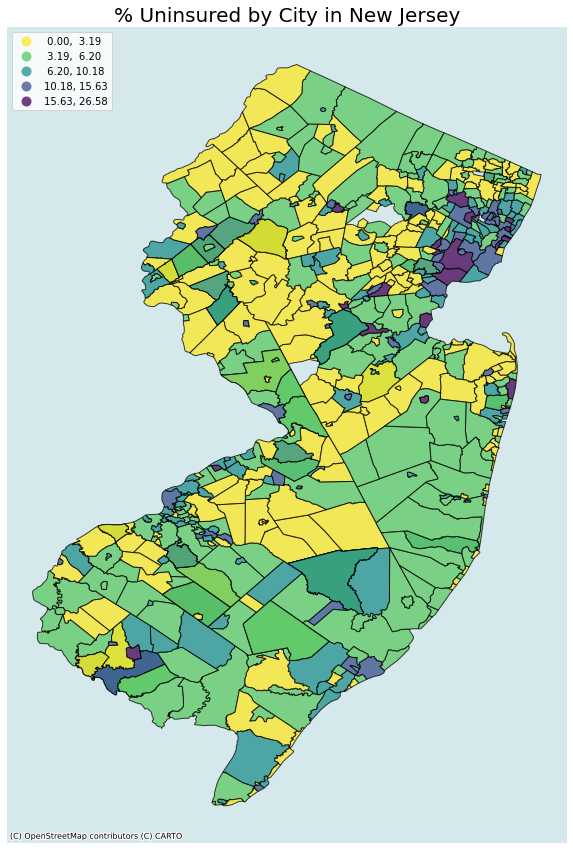

In [5]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(15, 15))

# Build choropleth
df.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme='natural_breaks',
    k=5, 
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Voyager,
)

plt.title('% Uninsured by City in New Jersey', fontsize=20)
ax.set_axis_off();

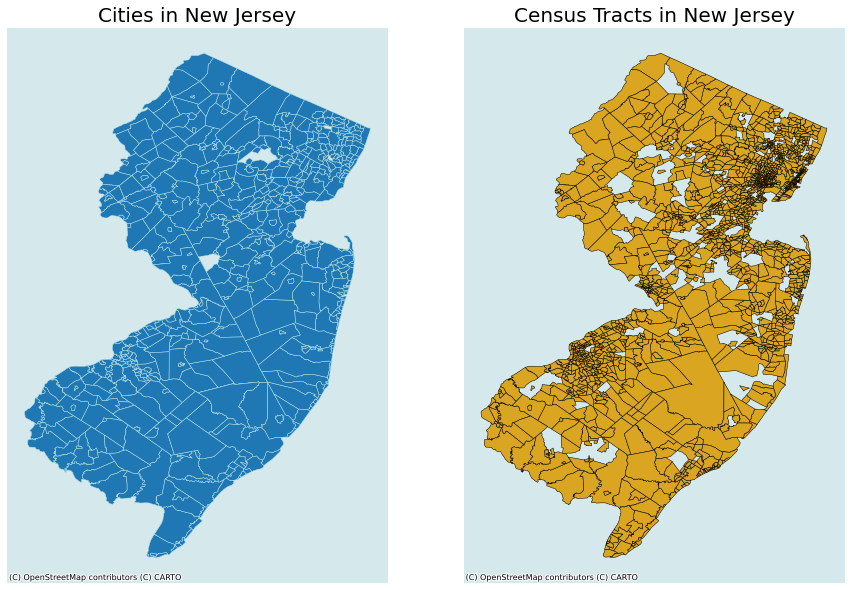

In [6]:
fig, ax = plt.subplots(1,2, figsize=(15,20))

df.plot(ax=ax[0], edgecolor = 'powderblue', linewidth = 0.5)
tract_info.plot(ax=ax[1], color = 'goldenrod',edgecolor = 'black', linewidth = 0.5)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)
ax[0].set_title('Cities in New Jersey', fontsize=20)
ax[1].set_title('Census Tracts in New Jersey', fontsize=20)
ax[0].axis('off')
ax[1].axis('off');


#### Areal Interpolation:
- Areal interpolation is the process making estimates from a source set of polygons to an overlapping but incongruent set of target polygons. 

- The simplest technique available in `tobler` is **simple areal interpolation** in which variables from the source data are weighted according to the overlap between source and target polygons, then reaggregated to fit the target polygon geometries

In [7]:
extensive_variables = list(df.drop(['State','County','City','geometry','Unemployment Rate (16 & Over)', '% Uninsured'], axis=1).columns)
results = area_interpolate(source_df=df, target_df=tract_info, intensive_variables = ['Unemployment Rate (16 & Over)'], extensive_variables=extensive_variables)

In [8]:
results.head()

,Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years","NUI, 26 to 34 years","NUI, 35 to 44 years","NUI, 45 to 54 years","NUI, 55 to 64 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",Unemployment Rate (16 & Over),geometry
0,12182.092654,1704.098957,65.501894,1.994449,7.872824,12.701489,2.099420,28.447137,8.607621,3.778955,...,36.110019,29.391876,53.115318,7.138027,0.000000,1.469594,0.0,3.778955,5.0,"POLYGON ((-74.99296 39.99683, -74.98721 39.999..."
1,14191.455374,10411.867964,411.032521,0.000000,49.546943,45.564070,72.169663,97.660052,73.125553,70.257884,...,210.136393,200.896127,260.001966,40.147362,0.000000,63.248027,0.0,13.701084,5.6,"POLYGON ((-74.36466 40.41247, -74.36124 40.413..."
2,11386.715745,1592.837206,61.225232,1.864230,7.358802,11.872200,1.962347,26.589804,8.045623,3.532225,...,33.752371,27.472861,49.647384,6.671980,0.000000,1.373643,0.0,3.532225,5.0,"POLYGON ((-74.97985 39.99100, -74.97782 39.993..."
3,359.379982,458.700603,68.270755,1.716202,4.150531,11.636092,19.827609,14.338197,9.481711,5.538098,...,36.539277,31.731478,15.969198,13.242749,1.290194,11.660436,0.0,22.347140,13.8,"POLYGON ((-74.46781 39.34745, -74.46588 39.348..."
4,58264.474800,3609.044688,96.185432,0.000000,0.000000,4.779400,25.091852,8.363951,54.365679,3.584550,...,72.288430,23.897002,96.185432,0.000000,0.000000,0.000000,0.0,0.000000,4.4,"POLYGON ((-74.92596 39.21036, -74.92369 39.210..."


In [9]:
# Create Uninsurance rate columns

results['% Uninsured'] = results['Uninsured Population']/results['City Population']*100
results['% African'] = results['NUI, African American']/results['Uninsured Population']*100
tract_info['% African'] = tract_info['NUI, African American']/tract_info['Uninsured Population']*100
results['% White'] = results['NUI, White']/results['Uninsured Population']*100
tract_info['% White'] = tract_info['NUI, White']/tract_info['Uninsured Population']*100


results.shape

(1831, 24)

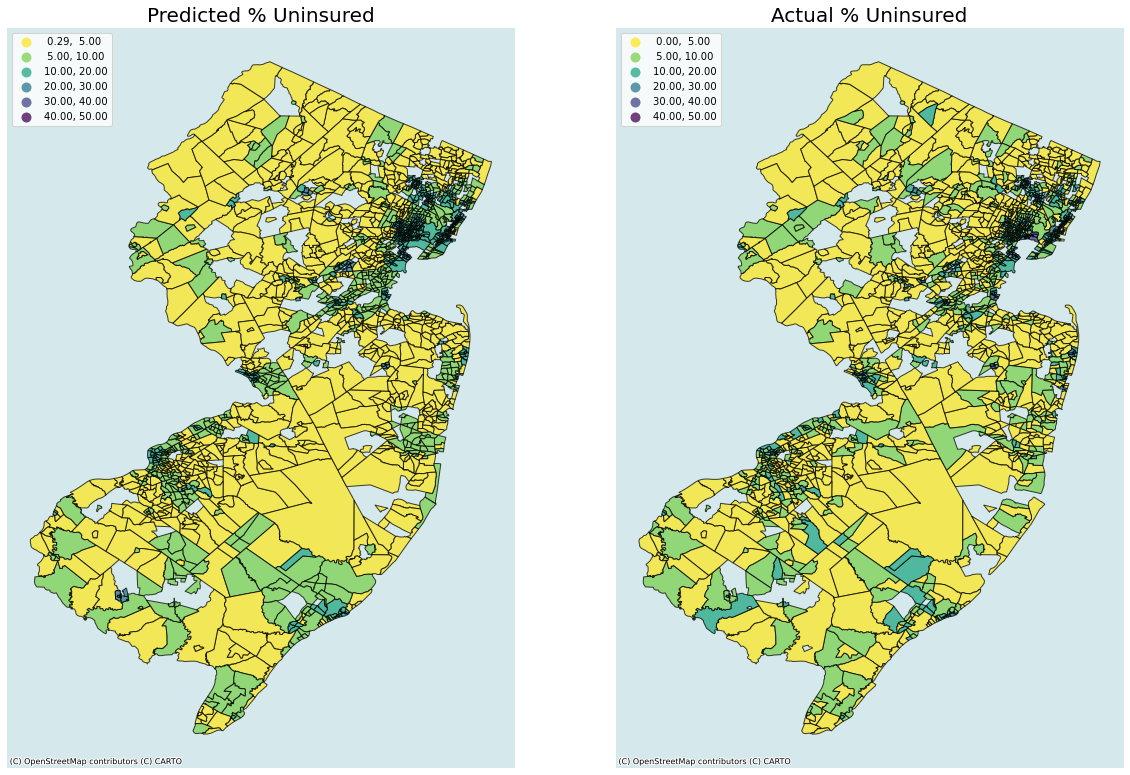

In [10]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured',fontsize=20)
ax[1].set_title('Actual % Uninsured',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

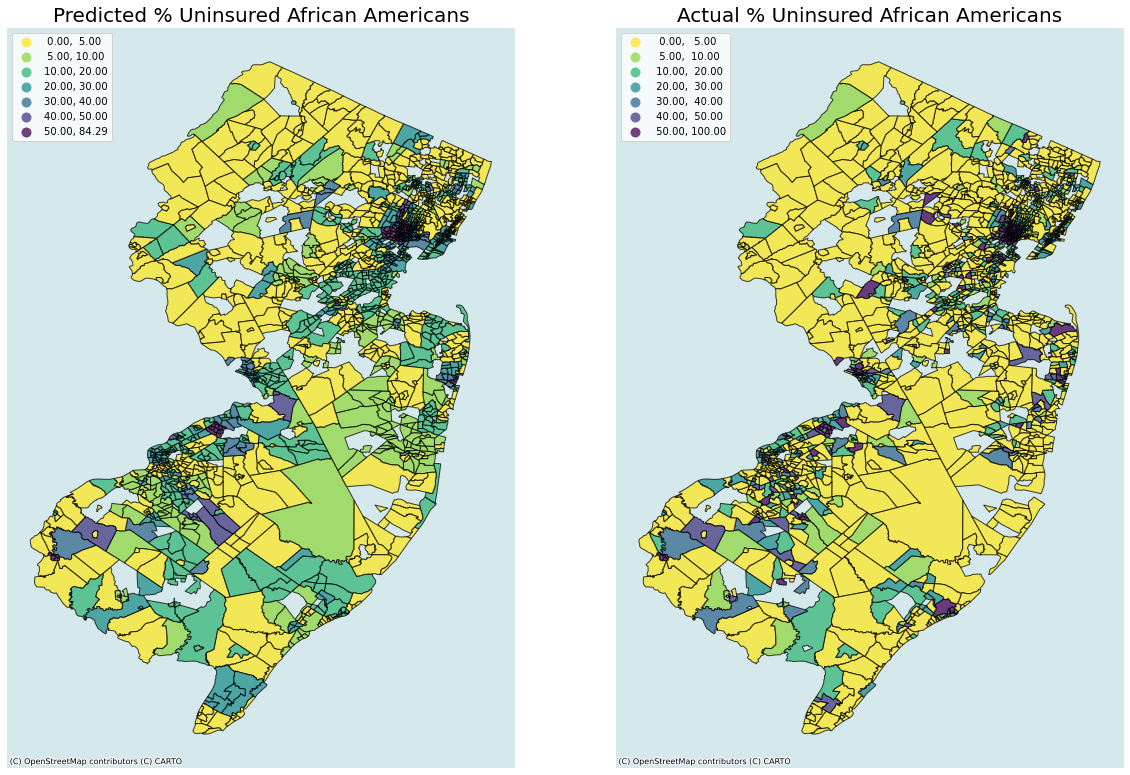

In [11]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% African', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% African', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured African Americans',fontsize=20)
ax[1].set_title('Actual % Uninsured African Americans',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

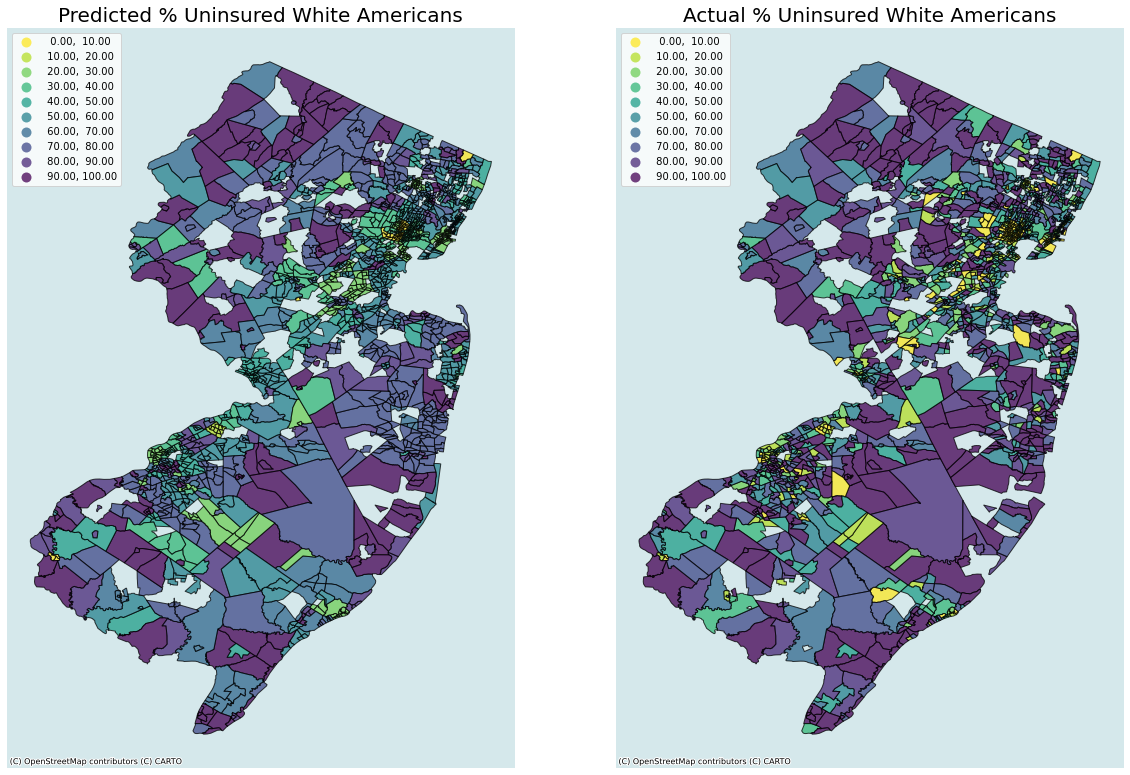

In [12]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% White', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[10,20,30,40,50,60,70,80,90,100]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% White', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[10,20,30,40,50,60,70,80,90,100]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured White Americans',fontsize=20)
ax[1].set_title('Actual % Uninsured White Americans',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');